In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.distributions import Categorical, Normal, MixtureSameFamily
from torch.optim.swa_utils import AveragedModel, SWALR

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

from datamodel import SPX, StockData
from model_testing import Model, WalkForwardAnalysis, create_lags
plt.rcParams["figure.figsize"] = (15,10)

In [2]:
class MDN(nn.Module):
    def __init__(self, in_dim, out_dim, hidden_dim, n_components):
        """
        Mixture density network.
        in_dim: Number of input variables
        out_dim: Number of output variables
        hidden_dim: Size of hidden layer
        n_components: Number of normal distributions to use in mixture
        """
        super().__init__()
        self.n_components = n_components
        # Last layer output dimension rationale:
        # Need two parameters for each distribution thus 2 * n_components.
        # Need each of those for each output dimension, thus that multiplication
        self.norm_network = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ELU(),
            nn.Dropout(),
            nn.Linear(hidden_dim, 2 * n_components * out_dim),
        )
        self.cat_network = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ELU(),
            nn.Dropout(),
            nn.Linear(hidden_dim, n_components * out_dim),
        )

    def forward(self, x):
        norm_params = self.norm_network(x)
        # Split so we get parameters for mean and standard deviation
        mean, std = torch.split(norm_params, norm_params.shape[1] // 2, dim=1)
        # We need rightmost dimension to be n_components for mixture
        mean = mean.view(mean.shape[0], -1, self.n_components)
        std = std.view(std.shape[0], -1, self.n_components)
        normal = Normal(mean, torch.exp(std))

        cat_params = self.cat_network(x)
        # Again, rightmost dimension must be n_components
        cat = Categorical(
            logits=cat_params.view(cat_params.shape[0], -1, self.n_components)
        )

        return MixtureSameFamily(cat, normal)

In [24]:
class MDNModel(Model):
    def __init__(self, in_dim, out_dim, hidden_dim, n_components):
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.hidden_dim = hidden_dim
        self.n_components = n_components
        self.scaler = StandardScaler()
        
    def fit(self, train_indep_var, train_dep_var):
        self.model = MDN(self.in_dim, self.out_dim, self.hidden_dim, self.n_components)
        optim = torch.optim.Adam(self.model.parameters())
        
        self.scaler.fit(train_indep_var)
        train_indep_var = torch.tensor(self.scaler.transform(train_indep_var), dtype=torch.float32)
        train_dep_var = torch.tensor(train_dep_var, dtype=torch.float32).reshape(-1, 1)
        
        self.model.train()
        for epoch in range(2500):
            optim.zero_grad()
            output = self.model(train_indep_var)
            loss = -output.log_prob(train_dep_var).sum()
            loss.backward()
            optim.step()
            
            if epoch % 100 == 0:
                print(f"Epoch {epoch} complete. Loss: {loss}")
            
    def loss(self, test_indep_var, test_dep_var):
        indep_var_tensor = torch.tensor(self.scaler.transform(test_indep_var), dtype=torch.float32)
        dep_var_tensor = torch.tensor(test_dep_var, dtype=torch.float32).reshape(-1, 1)
        
        self.model.eval()
        output = self.model(indep_var_tensor)
        result = {"mean": pd.Series(output.mean.detach().squeeze().numpy(), index=test_indep_var.index),
                  "pit": output.cdf(dep_var_tensor).detach().numpy(),
                  "r2": r2_score(test_dep_var, output.mean.detach().numpy())}
        return result

In [4]:
spx = SPX()
data = StockData(["^VIX"])

spx_wk_prices = spx.prices.resample("W-FRI").last()
spx_wk_returns = (np.log(spx_wk_prices) - np.log(spx_wk_prices.shift(1))).dropna()
spx_wk_vol = np.sqrt(spx.vol.resample("W-FRI").sum())

In [16]:
spx_vol_lags = create_lags(np.log(np.sqrt(spx.vol)), 21, "spx_vol")
vix_lags = create_lags(np.log(data.prices.VIX["close"]), 21, "vix")
spx_return_lags = create_lags(spx.returns, 21, "spx_returns")

indep_var = pd.concat([spx_vol_lags, vix_lags, spx_return_lags], axis=1).dropna()
dep_var = np.log(spx_wk_vol.shift(-1).dropna())

common_index = indep_var.index.intersection(dep_var.index)

indep_var = indep_var.loc[common_index]
dep_var = dep_var.loc[common_index]

In [35]:
model = MDNModel(len(indep_var.columns), 1, 250, 5)
model_test = WalkForwardAnalysis(indep_var, dep_var, model, splits=25, min_samples=156)
results = model_test.walk_forward_test()

predicted = pd.concat([n["mean"] for n in results])
r2 = [n["r2"] for n in results]

Epoch 0 complete. Loss: 587.5673828125
Epoch 100 complete. Loss: 141.20620727539062
Epoch 200 complete. Loss: 93.30654907226562
Epoch 300 complete. Loss: 68.67084503173828
Epoch 400 complete. Loss: 50.159461975097656
Epoch 500 complete. Loss: 49.854942321777344
Epoch 600 complete. Loss: 44.075218200683594
Epoch 700 complete. Loss: 59.64717483520508
Epoch 800 complete. Loss: 25.371976852416992
Epoch 900 complete. Loss: 27.184452056884766
Epoch 1000 complete. Loss: 21.293527603149414
Epoch 1100 complete. Loss: 30.879154205322266
Epoch 1200 complete. Loss: 28.325302124023438
Epoch 1300 complete. Loss: 10.244836807250977
Epoch 1400 complete. Loss: 2.4468255043029785
Epoch 1500 complete. Loss: 8.899739265441895
Epoch 1600 complete. Loss: -7.07141637802124
Epoch 1700 complete. Loss: 2.899371862411499
Epoch 1800 complete. Loss: -0.8865352869033813
Epoch 1900 complete. Loss: -9.78793716430664
Epoch 2000 complete. Loss: -13.749171257019043
Epoch 2100 complete. Loss: -2.889190435409546
Epoch 220

Epoch 500 complete. Loss: 101.47222137451172
Epoch 600 complete. Loss: 113.85343170166016
Epoch 700 complete. Loss: 78.46526336669922
Epoch 800 complete. Loss: 80.26988983154297
Epoch 900 complete. Loss: 62.58032989501953
Epoch 1000 complete. Loss: 39.9964714050293
Epoch 1100 complete. Loss: 62.250274658203125
Epoch 1200 complete. Loss: 29.67630958557129
Epoch 1300 complete. Loss: 27.534671783447266
Epoch 1400 complete. Loss: 50.39470291137695
Epoch 1500 complete. Loss: 18.696922302246094
Epoch 1600 complete. Loss: 12.961013793945312
Epoch 1700 complete. Loss: -1.6950616836547852
Epoch 1800 complete. Loss: -2.379537582397461
Epoch 1900 complete. Loss: 17.377941131591797
Epoch 2000 complete. Loss: -5.03093147277832
Epoch 2100 complete. Loss: -14.95956802368164
Epoch 2200 complete. Loss: -13.354177474975586
Epoch 2300 complete. Loss: 13.350214004516602
Epoch 2400 complete. Loss: -29.939260482788086
Split 7 complete.
Epoch 0 complete. Loss: 2062.799560546875
Epoch 100 complete. Loss: 551.

Epoch 1100 complete. Loss: 129.7279510498047
Epoch 1200 complete. Loss: 69.04824829101562
Epoch 1300 complete. Loss: 101.97998809814453
Epoch 1400 complete. Loss: 115.12299346923828
Epoch 1500 complete. Loss: 79.16804504394531
Epoch 1600 complete. Loss: 59.2159538269043
Epoch 1700 complete. Loss: 46.76924514770508
Epoch 1800 complete. Loss: 56.34104919433594
Epoch 1900 complete. Loss: 45.75819778442383
Epoch 2000 complete. Loss: 27.04521942138672
Epoch 2100 complete. Loss: 15.359336853027344
Epoch 2200 complete. Loss: 8.006540298461914
Epoch 2300 complete. Loss: 35.054439544677734
Epoch 2400 complete. Loss: 31.27562141418457
Split 14 complete.
Epoch 0 complete. Loss: 3299.398681640625
Epoch 100 complete. Loss: 850.5213623046875
Epoch 200 complete. Loss: 564.3604736328125
Epoch 300 complete. Loss: 382.26446533203125
Epoch 400 complete. Loss: 292.82177734375
Epoch 500 complete. Loss: 229.16165161132812
Epoch 600 complete. Loss: 215.00408935546875
Epoch 700 complete. Loss: 171.49969482421

Epoch 1700 complete. Loss: 53.678462982177734
Epoch 1800 complete. Loss: 84.6376953125
Epoch 1900 complete. Loss: 52.83209228515625
Epoch 2000 complete. Loss: 61.50011444091797
Epoch 2100 complete. Loss: 73.71192932128906
Epoch 2200 complete. Loss: 60.81414794921875
Epoch 2300 complete. Loss: 52.149940490722656
Epoch 2400 complete. Loss: 4.554351806640625
Split 21 complete.
Epoch 0 complete. Loss: 4584.79931640625
Epoch 100 complete. Loss: 1212.6524658203125
Epoch 200 complete. Loss: 770.1835327148438
Epoch 300 complete. Loss: 512.523681640625
Epoch 400 complete. Loss: 388.3760070800781
Epoch 500 complete. Loss: 322.658447265625
Epoch 600 complete. Loss: 276.5478820800781
Epoch 700 complete. Loss: 262.0019836425781
Epoch 800 complete. Loss: 222.2718505859375
Epoch 900 complete. Loss: 184.99935913085938
Epoch 1000 complete. Loss: 159.25547790527344
Epoch 1100 complete. Loss: 163.84536743164062
Epoch 1200 complete. Loss: 167.52606201171875
Epoch 1300 complete. Loss: 116.874755859375
Epoc

<AxesSubplot:>

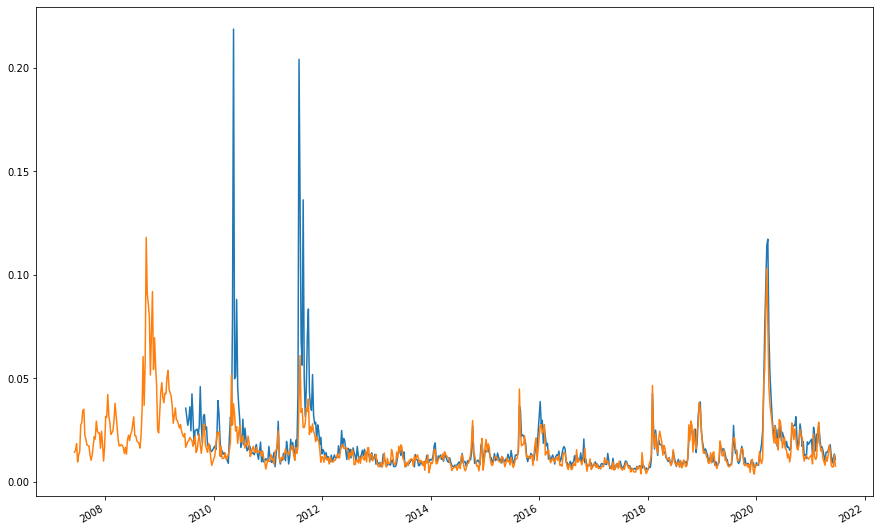

In [37]:
np.exp(predicted).plot()
np.exp(dep_var).plot()